In [2]:
import numpy as np
import networkx as nx
import rustworkx as rx
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from scipy.optimize import minimize
from itertools import product
import matplotlib.pyplot as plt
import random

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, EstimatorOptions
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeBrisbane, FakeCusco
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import os

import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
 
 
from qiskit.circuit.library import QAOAAnsatz
from qiskit.visualization import plot_histogram
from rustworkx.visualization import mpl_draw
from qiskit.providers.fake_provider import GenericBackendV2

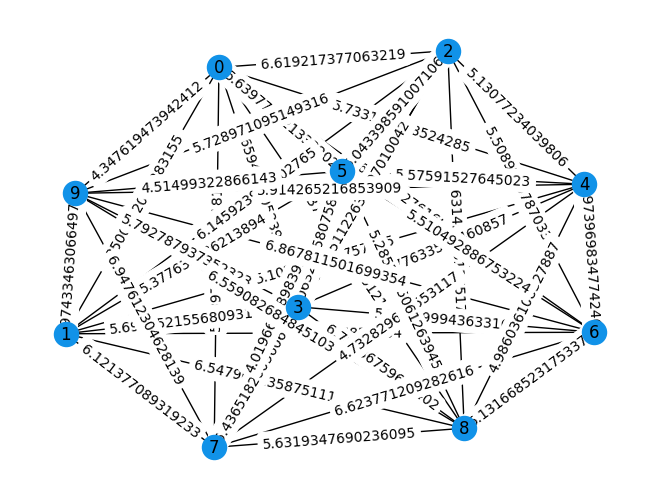

In [3]:
def construct_graph(graph_structure, graph_weight, n):
    graph = rx.PyGraph()
    graph.add_nodes_from(np.arange(0, n, 1))

    edge_list = []
    for (node, weight) in zip(graph_structure, graph_weight):
        edge_list.append((node[0], node[1], weight))

    # edge_list = [
    #     (0, 1, 1.0),
    #     (0, 2, 3.0),
    #     (0, 4, 1.0),
    #     (1, 2, 1.0),
    #     (2, 3, 1.0),
    #     (3, 4, 2.0),
    #     (4, 5, 6.0),
    # ]
    graph.add_edges_from(edge_list)
    
    return graph

p1, p2 = 0.4, 0.6
n = 10
generic_backend_ext = GenericBackendV2(n, seed=42)
graph_structure = list(generic_backend_ext.coupling_map)[::2]
num_edges = len(graph_structure)
graph_weight1 = np.random.uniform(1, 10, size=num_edges)
graph_weight2 = (np.max(graph_weight1) + np.min(graph_weight1)) - graph_weight1 + np.random.uniform(-1.5, 1.5, size=num_edges)

graph1 = construct_graph(graph_structure, graph_weight1, n)
graph2 = construct_graph(graph_structure, graph_weight2, n)
graph_weight = p1*graph_weight1+ p2*graph_weight2
graph = construct_graph(graph_structure, graph_weight, n)

# draw_graph(graph, node_size=600, with_labels=True)
mpl_draw(graph, with_labels=True, edge_labels=str, node_color="#1192E8")

In [4]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.
 
    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list
 
 
max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
hamil1 = SparsePauliOp.from_sparse_list(build_max_cut_paulis(graph1), n)
hamil2 = SparsePauliOp.from_sparse_list(build_max_cut_paulis(graph2), n)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIZIIIIZ', 'IIIZIIIIIZ', 'IIZIIIIIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IIIIIIIZZI', 'IIIIIIZIZI', 'IIIIIZIIZI', 'IIIIZIIIZI', 'IIIZIIIIZI', 'IIZIIIIIZI', 'IZIIIIIIZI', 'ZIIIIIIIZI', 'IIIIIIZZII', 'IIIIIZIZII', 'IIIIZIIZII', 'IIIZIIIZII', 'IIZIIIIZII', 'IZIIIIIZII', 'ZIIIIIIZII', 'IIIIIZZIII', 'IIIIZIZIII', 'IIIZIIZIII', 'IIZIIIZIII', 'IZIIIIZIII', 'ZIIIIIZIII', 'IIIIZZIIII', 'IIIZIZIIII', 'IIZIIZIIII', 'IZIIIZIIII', 'ZIIIIZIIII', 'IIIZZIIIII', 'IIZIZIIIII', 'IZIIZIIIII', 'ZIIIZIIIII', 'IIZZIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'IZZIIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[4.8500002 +0.j, 6.61921738+0.j, 5.16594116+0.j, 5.73318759+0.j,
 5.63977282+0.j, 6.65799428+0.j, 5.63978882+0.j, 5.37072544+0.j,
 4.34761947+0.j, 6.14592396+0.j, 5.69375216+0.j, 5.10216854+0.j,
 5.37763974+0.j, 4.30494079+0.j, 6.12137709+0.j, 6.54796624+0.j,
 5.97433463+0.j, 4.26119497+0.j, 5.13077234+0.

Parameters to be optimized: ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])


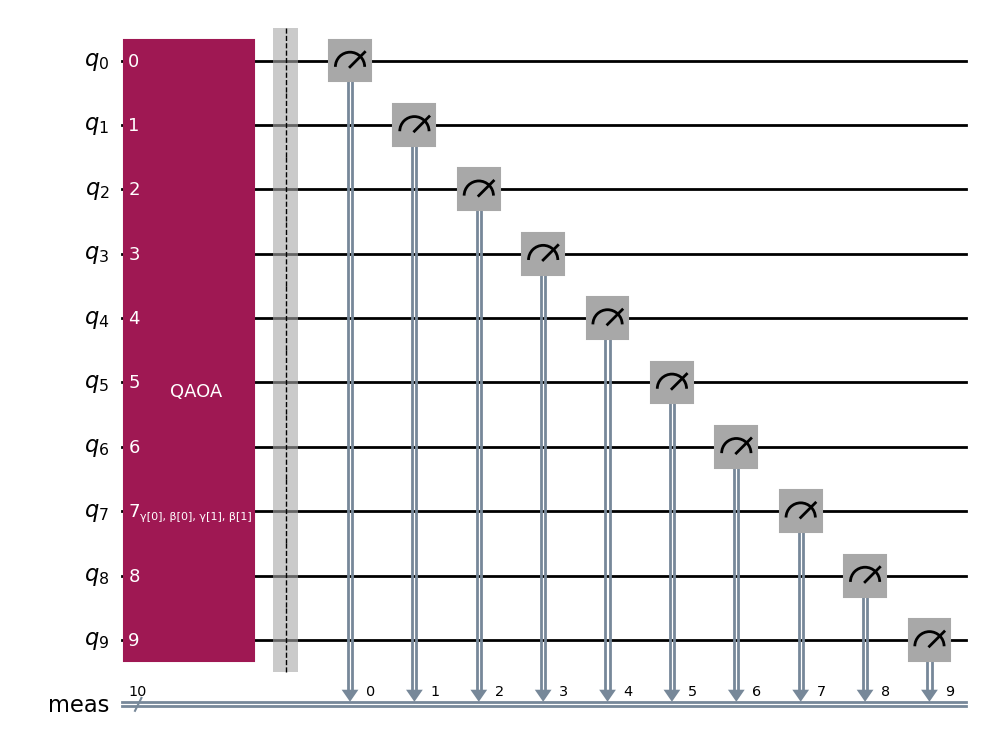

In [5]:
# 회로 생성
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()
print("Parameters to be optimized:", circuit.parameters)
circuit.draw('mpl', fold=-1)

In [6]:
IBM_YONSEI = os.getenv('IBM_YONSEI')

service = QiskitRuntimeService()

backend = service.backend('ibm_yonsei')
estimator = Estimator(backend)
sampler = Sampler(backend)

#backend_sim = FakeBrisbane()  # 또는 FakeManilaV2(), FakeCusco() 등
#backend_sim = AerSimulator.from_backend(backend)
backend_sim = AerSimulator()
estimator_sim = Estimator(backend_sim)
sampler_sim = Sampler(backend_sim)

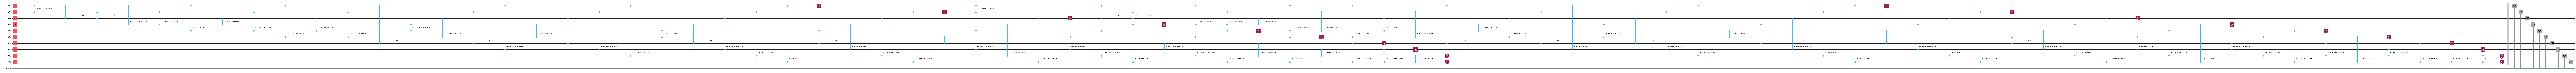

In [7]:
from qiskit_ibm_transpiler import generate_ai_pass_manager

#isa_circuit = ai_transpiler_pass_manager.run(circuit)

target = backend_sim.target
pm = generate_preset_pass_manager(target=target, optimization_level=2)
isa_circuit = pm.run(circuit)

# 트랜스파일된 회로에 맞게 해밀토니안도 레이아웃을 적용합니다.
#ias_hamiltonian = cost_hamiltonian.apply_layout(isa_circuit.layout)
isa_hamiltonian = cost_hamiltonian.apply_layout(isa_circuit.layout)
isa_hamil1 = hamil1.apply_layout(isa_circuit.layout)
isa_hamil2 = hamil2.apply_layout(isa_circuit.layout)
isa_circuit.draw('mpl', fold=-1)

In [8]:
def calculate_hypervolume(solutions, ref_point):
    hv = 0
    pareto_front = []
    for s1 in solutions:
        is_dominated = False
        for s2 in solutions:
            if s1[0] > s2[0] and s1[1] > s2[1]:
                is_dominated = True
                break
        if not is_dominated:
            pareto_front.append(s1)
            
    pareto_front.sort(key=lambda x: x[0])
    
    current_y = ref_point[1]
    for sol in pareto_front:
        hv += (sol[0] - ref_point[0]) * (current_y - sol[1])
        current_y = sol[1]
    
    return hv

In [9]:
def cost_func_sampler_hypervolume(params, circuit, qiskit_params, hamil1, hamil2, ref_point):
    
    # Sampler를 사용하기 때문에 session을 직접 생성합니다.
    sampler = sampler_sim
    # Sampler를 실행하여 측정 결과(counts)를 얻습니다.
    job = sampler.run([circuit.assign_parameters(dict(zip(qiskit_params, params)))], shots=1024)
    counts = job.result()[0].data.meas.get_counts()
    
    ns_solutions = sorted(counts.items(), key=lambda item: item[1], reverse=True)[:30]
    

    pubs_to_run = []
    
    # 측정 결과에서 비트스트링과 확률을 가져옵니다.
    for bitstring, _ in ns_solutions:
        state_circuit = QuantumCircuit(circuit.num_qubits)
        for i, bit in enumerate(bitstring):
            if bit == '1':
                state_circuit.x(i)
        
        # 각 상태 회로와 해밀토니안을 Estimator 작업 리스트에 추가합니다.
        pubs_to_run.append((state_circuit, hamil1))
        pubs_to_run.append((state_circuit, hamil2))

    # 모든 Estimator 작업을 한 번에 실행합니다.
    if pubs_to_run:
        result_estimator = estimator_sim.run(pubs_to_run).result()
        evs = [res.data.evs for res in result_estimator]
    else:
        return 0.0 # 측정된 해가 없을 경우 0 반환

    # 목적 함수 값 계산
    solution_vectors = []


    for i in range(0, len(evs), 2):
        cost1 = evs[i]
        cost2 = evs[i + 1]
        solution_vectors.append((cost1, cost2))

    hv = calculate_hypervolume(solution_vectors, ref_point)
    # 하이퍼볼륨을 최소화 문제로 변환하여 반환
    return -hv

In [10]:
# 참조점(Reference Point) 정의
# 최적화할 목적 함수들의 최악 값보다 더 나쁜 점을 설정해야 합니다.
ref_point = (1, 1)

# 초기 파라미터 생성
initial_params = np.random.rand(len(circuit.parameters))

# COBYLA를 사용하여 하이퍼볼륨 최적화 수행
result_hypervolume = minimize(
    cost_func_sampler_hypervolume,
    initial_params,
    args=(isa_circuit, circuit.parameters, isa_hamil1, isa_hamil2, ref_point),
    method="COBYLA",
    options={"maxiter": 200, "rhobeg": 1, "catol": 1e-3, "tol": 0.0001},
)

# 최적화된 파라미터 추출
optimized_params = result_hypervolume.x

print("하이퍼볼륨 최적화 결과:")
print(f"성공 여부: {result_hypervolume.success}")
print(f"최적화된 파라미터: {optimized_params}")
print(f"최종 목적 함수 값 (-Hypervolume): {result_hypervolume.fun}")

하이퍼볼륨 최적화 결과:
성공 여부: True
최적화된 파라미터: [-0.20109963  0.26905037 -0.07290262  0.50164633]
최종 목적 함수 값 (-Hypervolume): -795.584004046832


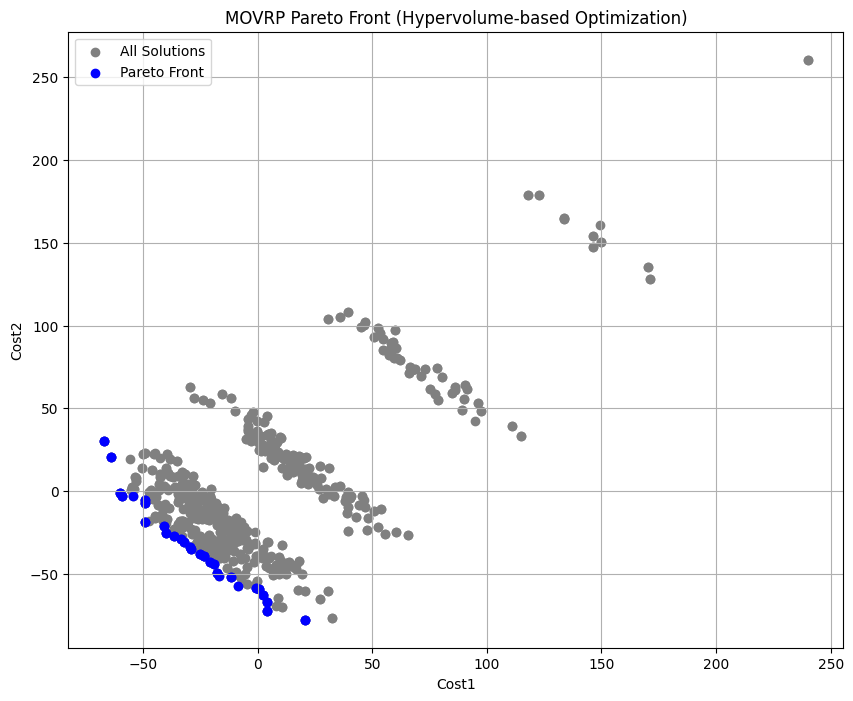


Final Pareto-optimal solutions:
Cost1: -67.18, Cost2: 30.32
Cost1: -67.18, Cost2: 30.32
Cost1: -63.91, Cost2: 20.45
Cost1: -63.91, Cost2: 20.45
Cost1: -59.88, Cost2: -1.39
Cost1: -59.88, Cost2: -1.39
Cost1: -59.20, Cost2: -2.66
Cost1: -59.20, Cost2: -2.66
Cost1: -54.38, Cost2: -2.72
Cost1: -49.18, Cost2: -5.44
Cost1: -49.18, Cost2: -5.44
Cost1: -49.10, Cost2: -7.37
Cost1: -49.10, Cost2: -7.37
Cost1: -48.97, Cost2: -18.52
Cost1: -48.97, Cost2: -18.52
Cost1: -40.83, Cost2: -21.15
Cost1: -40.83, Cost2: -21.15
Cost1: -40.06, Cost2: -25.34
Cost1: -40.06, Cost2: -25.34
Cost1: -36.64, Cost2: -27.16
Cost1: -36.64, Cost2: -27.16
Cost1: -33.31, Cost2: -29.18
Cost1: -33.31, Cost2: -29.18
Cost1: -31.91, Cost2: -30.95
Cost1: -31.91, Cost2: -30.95
Cost1: -29.67, Cost2: -33.70
Cost1: -29.67, Cost2: -33.70
Cost1: -28.91, Cost2: -34.94
Cost1: -28.91, Cost2: -34.94
Cost1: -25.24, Cost2: -37.97
Cost1: -25.24, Cost2: -37.97
Cost1: -23.39, Cost2: -38.89
Cost1: -23.39, Cost2: -38.89
Cost1: -23.18, Cost2: -

In [11]:
# 최적화된 매개변수로 회로를 최종 실행
sampler = sampler_sim
job = sampler.run([isa_circuit.assign_parameters(dict(zip(isa_circuit.parameters, optimized_params)))], shots=10000)
final_counts = job.result()[0].data.meas.get_counts()

# 모든 해의 목적 함수 값 계산
final_solutions = []
for sol_bitstring, count in final_counts.items():
    state_idx = int(sol_bitstring, 2)
    eff_cost = np.real(isa_hamil1.to_matrix()[state_idx, state_idx])
    ser_cost = np.real(isa_hamil2.to_matrix()[state_idx, state_idx]) 
    final_solutions.append((eff_cost, ser_cost))


# 파레토 전선 추출
final_pareto_front = []
for s1 in final_solutions:
    is_dominated = False
    for s2 in final_solutions:
        if s1[0] > s2[0] and s1[1] > s2[1]:
            is_dominated = True
            break
    if not is_dominated:
        final_pareto_front.append(s1)

# 파레토 전선 시각화
plt.figure(figsize=(10, 8))
all_eff_costs = [s[0] for s in final_solutions]
all_ser_costs = [s[1] for s in final_solutions]
pareto_eff_costs = [s[0] for s in final_pareto_front]
pareto_ser_costs = [s[1] for s in final_pareto_front]

plt.scatter(all_eff_costs, all_ser_costs, c='gray', label='All Solutions')
plt.scatter(pareto_eff_costs, pareto_ser_costs, c='blue', label='Pareto Front')
plt.xlabel('Cost1')
plt.ylabel('Cost2')
plt.title('MOVRP Pareto Front (Hypervolume-based Optimization)')
plt.legend()
plt.grid(True)
plt.show()

print("\nFinal Pareto-optimal solutions:")
for sol in sorted(final_pareto_front, key=lambda x: x[0]):
    print(f"Cost1: {sol[0]:.2f}, Cost2: {sol[1]:.2f}")